# Multivariate normal density integral

In this example notebook, we show how to create a target integral which can be integrated by treeQuadrature's methods. Here, our integral involves the probability density function of a multivariate normal:

$$ p(x|\mu,\Sigma) = \frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}} \text{exp}\left(-\frac{1}{2}(x-\mu)'\Sigma^{-1}(x-\mu)\right),$$

where, in our example, $\mu = [0]^d$ and $\Sigma=\text{diag}_d(1/200)$, where $d$ is the dimensions of the distribution. Here, we aim to numerically approximate the multivariate definite integral:

$$\int_{-1}^{1} p(x|\mu,\Sigma) dx = \text{Erf}(10)^d\approx 1,$$

where the limits are $[-1, 1]$ in each dimension of $d$, and $\text{Erf}$ is the error function:

$$\text{Erf}(z) = \frac{2}{\sqrt{\pi}} \int_{0}^{z} \exp(-t^2) dt.$$

We first define a class that wraps the `MultivariateNormal` density class in the `treeQuadrature` package.

In [1]:
import treeQuadrature as tq

class SimpleGaussian:
    def __init__(self, D):
        self.D = D
        self.d = tq.exampleDistributions.MultivariateNormal(D=D, mean=[0.0]*D, cov=1/200)
        self.low = -1.0
        self.high = 1.0
        self.answer = 1
        
    def pdf(self, X):
        return self.d.pdf(X)

Visualising this distribution for the 1d case, we see that the majority of integral mass is located within a small region.

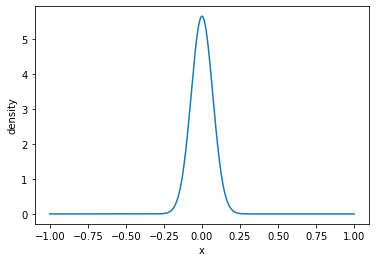

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# define integrand in 1d
problem = SimpleGaussian(1)

# plot
x = np.linspace(-1, 1, 1000)
dens = problem.pdf(x)
plt.plot(x, dens)
plt.xlabel('x')
plt.ylabel('density')
plt.show()

The ratio of the volume contributing substantively to the integral to the volume of the bounding box gets smaller in higher dimensions. We illustrate this in two dimensions.

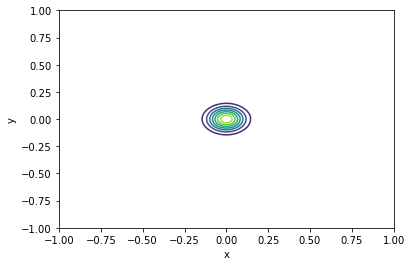

In [3]:
# define integrand in 2d
problem = SimpleGaussian(2)

# plot
import matplotlib.pyplot as plt
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([[problem.pdf([xs, ys])[0,0] for xs in x] for ys in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Defining the integrator

We now define an integrator that does the following:

1. Draws $N$ samples from the multivariate normal distribution.
2. Constructs a single "root" container that has all $N$ samples in it.
3. Repeatedly splits the container (and its children) into two until all containers have fewer than $P$ samples. Here, we use the `minSseSplit` rule to determine how containers should be split: this chooses a splitting approach where the children are chosen to minimise the function evaluation variance, and the splits are always along the coordinate axes.
4. Use the containers to numerically integrate the function. Here, we sample 100 function values uniformly within each container and calculate the median of the function values: the contribution of a given container to the overall integral is then this median function value multiplied by its (cuboidal) volume.

Our function when called evalutes the integral, returning the integral value, the containers and the contributions of each to the overall integral.

In [4]:
from queue import SimpleQueue

# Define the Integrator we gonna be testing today
class SimpleIntegrator:
    def __init__(self, N, P):
        self.N = N
        self.P = P
        
    def __call__(self, problem):        
        # Draw samples
        X = problem.d.rvs(self.N)
        y = problem.pdf(X)
        
        # Construct root container using paired draws (X, y)
        D = problem.D
        root = tq.Container(X, y, mins=[problem.low]*D, maxs=[problem.high]*D)
        
        # Construct tree using a FIFO queue
        finished_containers = []
        q = SimpleQueue()
        q.put(root)

        while not q.empty():

            c = q.get()

            if c.N <= self.P:
                finished_containers.append(c)
            else:
                children = tq.splits.minSseSplit(c)
                for child in children:
                    q.put(child)

        # Integrate containers
        contributions = [tq.containerIntegration.randomIntegral(cont, problem.pdf, n=100) for cont in finished_containers]
        int_approx = np.sum(contributions)
        
        return int_approx, finished_containers, contributions

We then use our integrator to the two-dimensional integral of the multivariate Gaussian target defined above.

In [5]:
# set number of samples of function and minimum number of draws per leaf container
N = 10_000
P = 40

# define integrator
integ = SimpleIntegrator(N, P)

# perform integration
G, fcs, cs = integ(problem)

We can examine the error in our approximation of the integral.

In [6]:
print("error =", str(100 * (G - problem.answer) / problem.answer), "%")

error = -4.827232923193392 %


We can then visualise the contribution of each of the containers to the overall integral value.

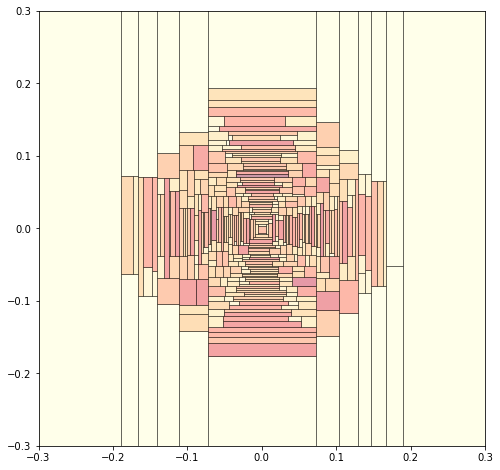

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.set_xlim([-0.3,0.3])
ax.set_ylim([-0.3,0.3])
cmap = cm.get_cmap('YlOrRd', 256)

cs = tq.utils.scale(cs)

for container, contribution in zip(fcs, cs):
    tq.visualisation.plotContainer(ax, container, plot_samples=False,
                                   fill=True, ec='black', facecolor=cmap(contribution), alpha=0.4)